# 3.1 추론 기반 기법과 신경망
## 3.1.3 신경망에서의 단어 처리

In [2]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c, W)
print(h)

[[ 1.79250905 -0.50931768 -0.10766139]]


In [3]:
import sys 
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 1.27228106 -0.08896261  1.09267493]]


In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * ( h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 0.15082849  0.71782185  1.12631506 -0.3857218   0.26804631  1.29969319
  -0.28771805]]


In [6]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


# 3.3. 학습 데이터 준비

## 3.3.1 맥락과 타깃

In [7]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [9]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


# 3.3.2 원핫 표현으로 변환

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [12]:
print(vocab_size)
print(target)
print(contexts)

7
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


# 3.4 CBOW 모델 구현

In [15]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        self.word_vecs = W_in
        
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da += 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

# 3.4 CBOW 모델 구현
## 3.4.1 학습 코드 구현

| epoch 1 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  repeat 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  repeat 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  repeat 1 / 2 | time 0[s] |

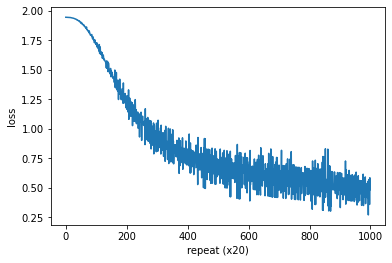

In [17]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size=1)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

